# Generate recommendations for Cycle 2 using ART 

Tested using **ART_v3.6** kernel on the jprime.lbl.gov server.

#### Running the cells below will generate:

- a file for ART front end
- several standard ART output files (containing recommendations, predictive accuracy metrics, plots of predictions vs observations for the train data set, pickle file containing previously trained ART object)


## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`

or pull the latest version.

In [1]:
import sys
sys.path.append('../../AutomatedRecommendationTool')
    
from edd_utils import login, export_study
from art.core import *
import pickle

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## User parameters

Definitions for EDD study export:

In [2]:
user_params = {
    'study_slug': 'multiomics-data',
    'edd_server': 'public-edd.agilebiofoundry.org'
}


ART input parameters:

In [3]:
user_params['num_recommendations'] = 10
user_params['output_directory'] = '../data/art_output/'


## Getting the designs and production data from EDD

Export the EDD study that contains isoprenol production data using `edd-utils` package:

In [4]:
session = login(edd_server=user_params['edd_server'], user='tradivojevic')


Password for tradivojevic:  ················


In [5]:
df = export_study(session, user_params['study_slug'], edd_server=user_params['edd_server'])
df.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,9014,Multiomics data,9111,Strain 1,ACCOAC_1.0_MDH_1.0_PTAr_2.0_CS_0.0_ACACT1r_2.0...,Metabolomics,9245,Strain 1,cid:15983957,isopentenyl diphosphate(3-),0,mg/L,0.00000,9.0
1,9014,Multiomics data,9112,Strain 2,ACCOAC_1.0_MDH_2.0_PTAr_2.0_CS_2.0_ACACT1r_2.0...,Metabolomics,9235,Strain 2,cid:15983957,isopentenyl diphosphate(3-),0,mg/L,0.55210,9.0
2,9014,Multiomics data,9113,Strain 3,ACCOAC_1.0_MDH_0.0_PTAr_0.0_CS_2.0_ACACT1r_1.0...,Metabolomics,9261,Strain 3,cid:15983957,isopentenyl diphosphate(3-),0,mg/L,0.34920,9.0
3,9014,Multiomics data,9114,Strain 4,ACCOAC_1.0_MDH_1.0_PTAr_1.0_CS_1.0_ACACT1r_2.0...,Metabolomics,9247,Strain 4,cid:15983957,isopentenyl diphosphate(3-),0,mg/L,0.55185,9.0
4,9014,Multiomics data,9115,Strain 5,ACCOAC_2.0_MDH_0.0_PTAr_2.0_CS_1.0_ACACT1r_1.0...,Metabolomics,9266,Strain 5,cid:15983957,isopentenyl diphosphate(3-),0,mg/L,0.08012,9.0


Keep only the necesarry columns:

In [6]:
df = df[['Line Name','Line Description','Measurement Type', 'Value']]
df.head()

,Line Name,Line Description,Measurement Type,Value
0,Strain 1,ACCOAC_1.0_MDH_1.0_PTAr_2.0_CS_0.0_ACACT1r_2.0...,isopentenyl diphosphate(3-),0.00000
1,Strain 2,ACCOAC_1.0_MDH_2.0_PTAr_2.0_CS_2.0_ACACT1r_2.0...,isopentenyl diphosphate(3-),0.55210
2,Strain 3,ACCOAC_1.0_MDH_0.0_PTAr_0.0_CS_2.0_ACACT1r_1.0...,isopentenyl diphosphate(3-),0.34920
3,Strain 4,ACCOAC_1.0_MDH_1.0_PTAr_1.0_CS_1.0_ACACT1r_2.0...,isopentenyl diphosphate(3-),0.55185
4,Strain 5,ACCOAC_2.0_MDH_0.0_PTAr_2.0_CS_1.0_ACACT1r_1.0...,isopentenyl diphosphate(3-),0.08012


**Read designs information from `Line Description` and store into separate columns**

Add columns for each reaction:

In [7]:
reactions = df['Line Description'][0].split('_')[::2]
for rxn in reactions:
    df[rxn] = None

df.tail()

,Line Name,Line Description,Measurement Type,Value,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
91,Strain 92,ACCOAC_0.0_MDH_0.0_PTAr_2.0_CS_2.0_ACACT1r_0.0...,isopentenyl diphosphate(3-),0.00000,None,None,None,None,None,None,None,None
92,Strain 93,ACCOAC_1.0_MDH_2.0_PTAr_0.0_CS_0.0_ACACT1r_0.0...,isopentenyl diphosphate(3-),0.00000,None,None,None,None,None,None,None,None
93,Strain 94,ACCOAC_0.0_MDH_2.0_PTAr_0.0_CS_1.0_ACACT1r_0.0...,isopentenyl diphosphate(3-),0.00000,None,None,None,None,None,None,None,None
94,Strain 95,ACCOAC_0.0_MDH_1.0_PTAr_2.0_CS_0.0_ACACT1r_1.0...,isopentenyl diphosphate(3-),0.00000,None,None,None,None,None,None,None,None
95,WT,Wild type E. coli,isopentenyl diphosphate(3-),0.46188,None,None,None,None,None,None,None,None


And assign values for each reaction and line:

In [8]:
for i in range(len(df)):
    if df['Line Name'][i]=='WT':
        for r in range(len(reactions)):
            df.iloc[i, (4+r)] = float(1)
    else:
        values = df.loc[i]['Line Description'].split('_')[1::2]
        for r,value in zip(range(len(reactions)),values):
            df.iloc[i, (4+r)] = float(value)

df = df.drop(columns='Line Description')


Each design (line) involves the modification of up to 8 fluxes (1 -> keep the same; 2-> double flux, 0-> knock reaction out):

In [9]:
df.tail()

,Line Name,Measurement Type,Value,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
91,Strain 92,isopentenyl diphosphate(3-),0.00000,0,0,2,2,0,2,0,2
92,Strain 93,isopentenyl diphosphate(3-),0.00000,1,2,0,0,0,2,2,0
93,Strain 94,isopentenyl diphosphate(3-),0.00000,0,2,0,1,0,2,1,1
94,Strain 95,isopentenyl diphosphate(3-),0.00000,0,1,2,0,1,1,0,2
95,WT,isopentenyl diphosphate(3-),0.46188,1,1,1,1,1,1,1,1


Rename `Value` column with the formal metabolite name:

In [10]:
production_name = df['Measurement Type'][0]
df = df.rename(columns={'Value': production_name})
df = df.drop(columns='Measurement Type')
df.tail()


,Line Name,isopentenyl diphosphate(3-),ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
91,Strain 92,0.00000,0,0,2,2,0,2,0,2
92,Strain 93,0.00000,1,2,0,0,0,2,2,0
93,Strain 94,0.00000,0,2,0,1,0,2,1,1
94,Strain 95,0.00000,0,1,2,0,1,1,0,2
95,WT,0.46188,1,1,1,1,1,1,1,1


Pivot the dataframe back to EDD format, now including all the reaction names and modifications:

In [11]:
df = df.set_index('Line Name').stack().reset_index()
df.columns = ['Line Name', 'Measurement Type', 'Value']
df.head()

,Line Name,Measurement Type,Value
0,Strain 1,isopentenyl diphosphate(3-),0.0
1,Strain 1,ACCOAC,1.0
2,Strain 1,MDH,1.0
3,Strain 1,PTAr,2.0
4,Strain 1,CS,0.0


Save this dataframe to a file for ART front end:

In [12]:
data_file = '../data/ART_training_EDDstyle.csv'
df.to_csv(data_file, header=True, index=False)

Store the names of all variables:

In [13]:
variables = df['Measurement Type'][df['Line Name']=='Strain 1'].tolist()


# Run ART 

## Train ART

A dictionary that contains the settings for ART:

In [14]:
art_params = {
    'response_var': [variables[0]],
    'input_var': variables[1:],
    'seed': 10,
    'num_recommendations': user_params['num_recommendations'],   
    'cross_val': True,
    'recommend': False,
    'output_directory': user_params['output_directory']
}

Run ART (takes around 25min) or load the previously run model.

In [15]:
run_art = True

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6595131800190912, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6462472422719335, but should be close to 0.8. Try to increase the number of tuning steps.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9298139747992613, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


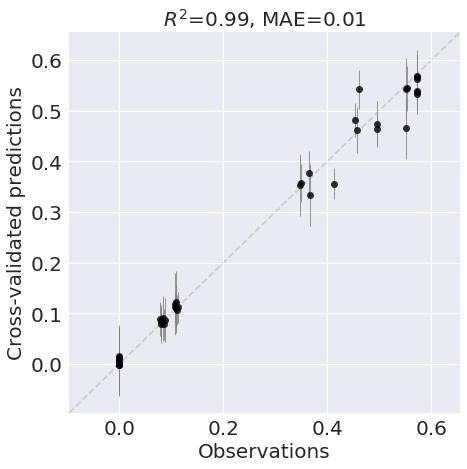

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


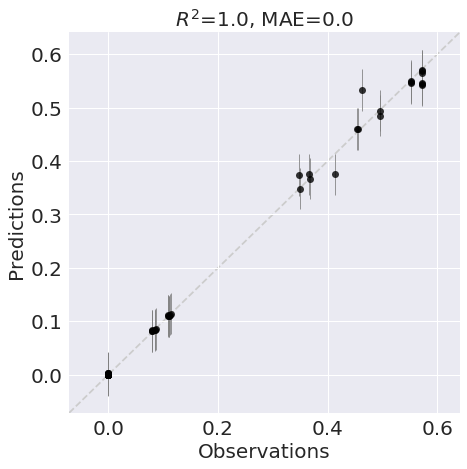

CPU times: user 24min 16s, sys: 12min 42s, total: 36min 58s
Wall time: 20min 59s


In [16]:
%%time
if run_art:
    art = RecommendationEngine(df, **art_params)
else:
    with open(os.path.join(art_params['output_directory'], 'art.pkl'), 'rb') as output:
        art = pickle.load(output)

Take a look at the predictive accuracy metrics:

In [17]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.204693,inf,0.155104,0.065956,-0.730791
Random Forest Regressor,0.026081,NaN,0.050578,0.003238,0.915022
TPOT Regressor,0.005641,NaN,0.015564,0.000274,0.992808
Support Vector Regressor,0.106237,inf,0.074779,0.016878,0.557095
Kernel Ridge Regressor,0.092691,inf,0.078948,0.014824,0.610985
K-NN Regressor,0.118036,NaN,0.101839,0.024304,0.362238
Gaussian Process Regressor,0.086795,inf,0.076816,0.013434,0.647471
Gradient Boosting Regressor,0.052986,inf,0.052229,0.005535,0.854744
Ensemble Model,0.008256,inf,0.014691,0.000284,0.992548


ART's ensemble model outperforms all individual models in terms of $R^2$.

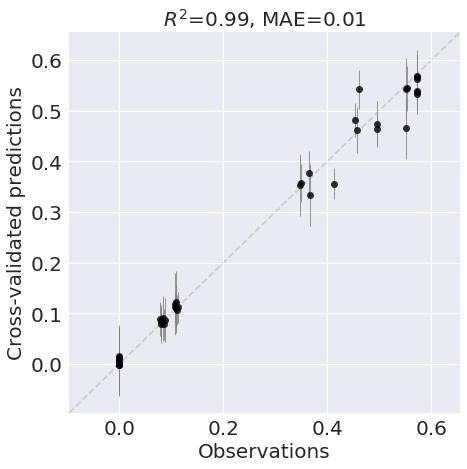

In [18]:
plot.predictions_vs_observations(art, cv_flag=True, errorbars_flag=True)

In [19]:
utils.save_pkl_object(art)


## Recommend new designs

Find all possible values for input variables:

In [20]:
categories = set(df['Value'][df['Measurement Type'].isin(art.input_var)])


Create the set of all possible designs:

In [22]:
n_modifications = len(categories)
num_of_reactions = art.num_input_var
num_of_designs = n_modifications**num_of_reactions
strains = np.zeros((num_of_designs, num_of_reactions))


In [23]:
i = 0

for d1 in range(3):
    for d2 in range(3):
        for d3 in range(3):
            for d4 in range(3):
                for d5 in range(3):
                    for d6 in range(3):
                        for d7 in range(3):
                            for d8 in range(3):
                                strains[i,:] = np.hstack((d1,d2,d3,d4,d5,d6,d7,d8)).astype(int)
                                i+=1

Calculate mean predicted production and standard deviation for all possible designs:

In [52]:
pp_mean, pp_std = art.post_pred_stats(strains)


The relative engineering accuracy is set to one percent to make sure recommendations are different from the input data.

In [53]:
art.rel_eng_accuracy = 0.01

Here we take the exploitative approach for finding recommendations - the objective function is defined as the mean predicted production (the parameter for exploration is set to $\alpha=0$).

In [54]:
obj_func = pp_mean 
data = np.hstack((strains, obj_func, obj_func))

art.recommend(data=data)
art.recommendations


,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,isopentenyl diphosphate(3-)
0,2.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.573584
1,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,0.572193
2,1.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.572167
3,2.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,0.572039
4,2.0,2.0,1.0,2.0,2.0,1.0,0.0,1.0,0.571967
5,2.0,2.0,2.0,2.0,2.0,1.0,0.0,1.0,0.571282
6,2.0,2.0,1.0,2.0,2.0,2.0,0.0,2.0,0.570968
7,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,0.570915
8,1.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,0.570771
9,2.0,1.0,2.0,2.0,2.0,2.0,0.0,1.0,0.570769


For all recommended designs, CS and ACACT1r reaction fluxes should double and PPCK should be knockout. 

Change the last column name to indicate it is predicted:

In [55]:
pred_col_name = 'Mean predicted Isoprenol [mg/L]'
art.recommendations = art.recommendations.rename(columns={art_params['response_var'][0]: pred_col_name})


Add standard deviation predictions for the recommendations:

In [56]:
pp_rec_mean, pp_rec_std = art.post_pred_stats(art.recommendations.values[:,:-1])
art.recommendations['SD Isoprenol [mg/L]'] = pp_rec_std.copy()


Visualize the predicted distribution for all recommendations:

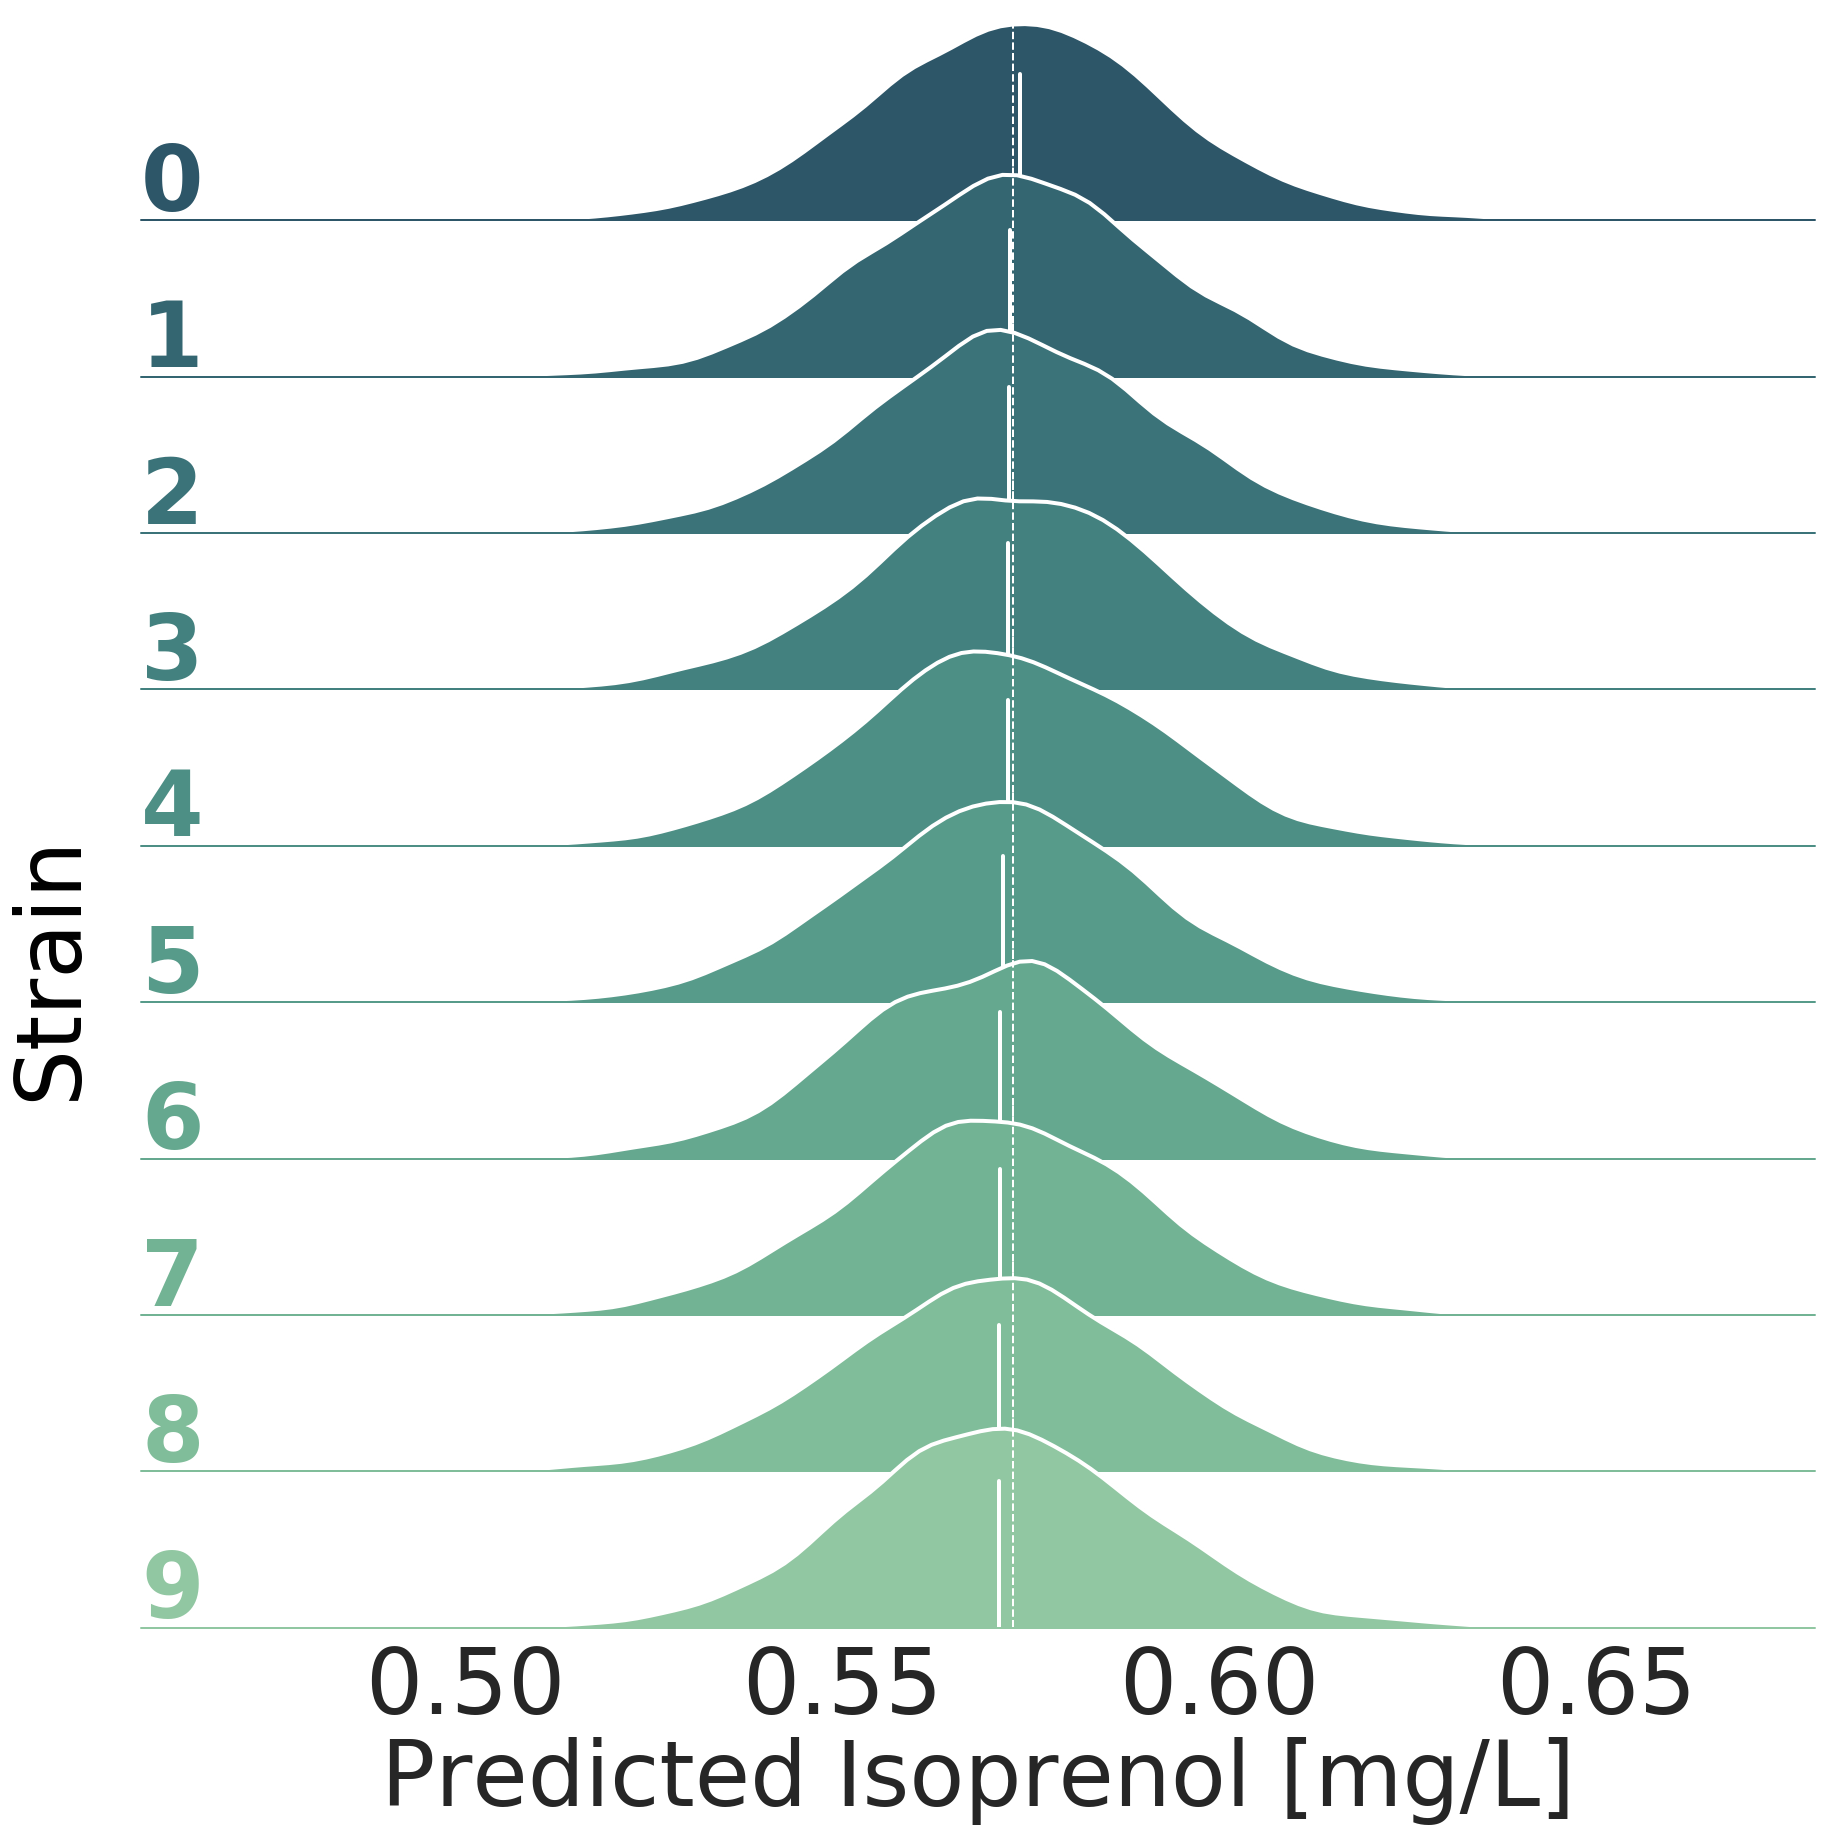

In [33]:
plot.recomm_distribution(art, art.find_current_best(), [pred_col_name])


Assign Line Name to each of the recommendations and save the file:

In [57]:
n_instances = len(set(df['Line Name']))
art.recommendations.insert(loc=0, column='Line Name', value=['Strain ' + str(n_instances+i) for i in range(1,art_params['num_recommendations']+1)])
art.recommendations.head()


,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Mean predicted Isoprenol [mg/L],SD Isoprenol [mg/L]
0,Strain 97,2.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.573584,0.019785
1,Strain 98,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,0.572193,0.019752
2,Strain 99,1.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.572167,0.019752
3,Strain 100,2.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,0.572039,0.019787
4,Strain 101,2.0,2.0,1.0,2.0,2.0,1.0,0.0,1.0,0.571967,0.019780


In [58]:
rec_filename = f'{art.outDir}/recommendations.csv'
art.recommendations.to_csv(rec_filename, header=True, index=False)